In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Input
)
from tensorflow.keras.callbacks import ModelCheckpoint
import PIL
import json
# Custom function to load dataset
def load_images_from_directory(folder_path, img_size=(128, 128)):
    labels = []
    images = []
    class_names = sorted(os.listdir(folder_path))
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for filename in os.listdir(class_folder):
            if filename.endswith('.tif') or filename.endswith('.jpg') or filename.endswith('.png'):
                img_path = os.path.join(class_folder, filename)
                try:
                    img = PIL.Image.open(img_path).convert("RGB")
                    img = img.resize(img_size)
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(label)

                except Exception as e:
                    print(f"Error loading image: {img_path}")
                    continue
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_names

# Load datasets
base_dir = '/content/drive/MyDrive/new_dataset'
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/validation'
test_dir = f'{base_dir}/test'

train_ds, train_labels, train_classes = load_images_from_directory(train_dir)
val_ds, val_labels, _ = load_images_from_directory(val_dir)
test_ds, test_labels, _ = load_images_from_directory(test_dir)

# Normalize and preprocess datasets
def preprocess(features, labels):
    features = tf.cast(features, tf.float32) / 255.0  # Normalize and convert
    return features, labels

train_tensor_ds = tf.data.Dataset.from_tensor_slices((train_ds, train_labels)).map(preprocess)
val_tensor_ds = tf.data.Dataset.from_tensor_slices((val_ds, val_labels)).map(preprocess)
test_tensor_ds = tf.data.Dataset.from_tensor_slices((test_ds, test_labels)).map(preprocess)

# Shuffle and batch datasets
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 8

train_tensor_ds = train_tensor_ds.shuffle(5000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_tensor_ds = val_tensor_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_tensor_ds = test_tensor_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Residual Block
def residual_block(input_tensor, filters, stride=1):
    shortcut = input_tensor
    # First Convolution
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second Convolution
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Add Shortcut Path
    if stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x
  # ResNet-18 Model
def resnet18(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolution + MaxPooling
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Residual Blocks
    for filters, blocks, stride in [(64, 2, 1), (128, 2, 2), (256, 2, 2), (512, 2, 2)]:
        for block in range(blocks):
            x = residual_block(x, filters, stride if block == 0 else 1)

    # Global Average Pooling + Dense Layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

# Define Model
input_shape = (128, 128, 3)
num_classes = 14
model = resnet18(input_shape, num_classes)
model.summary()

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1,
    decay_steps=1000,
    alpha=0.01
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 64, 64, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 11,198,094 (42.72 MB)

 Trainable params: 11,188,494 (42.68 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
# Path to save the model
checkpoint_path = '/content/drive/MyDrive/resnet_model_sgd_custom.keras'

# Callback for saving the model
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model for 8 epochs and save training history
history = model.fit(
    train_tensor_ds,
    validation_data=val_tensor_ds,
    epochs=5,
    callbacks=[checkpoint_cb]
)

# Save training history
history_path = '/content/drive/MyDrive/training_history_sgd_custom.json'
with open(history_path, 'w') as f:
    json.dump(history.history, f)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_tensor_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/5
1263/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2757 - loss: 2.0997
Epoch 1: saving model to /content/drive/MyDrive/resnet_model_sgd_custom.keras
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.2757 - loss: 2.0996 - val_accuracy: 0.2722 - val_loss: 2.0437
Epoch 2/5
1262/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2843 - loss: 2.0960
Epoch 2: saving model to /content/drive/MyDrive/resnet_model_sgd_custom.keras
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.2844 - loss: 2.0959 - val_accuracy: 0.2774 - val_loss: 2.0387
Epoch 3/5
1263/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2900 - loss: 2.0742
Epoch 3: saving model to /content/drive/MyDrive/resnet_model_sgd_custom.keras
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.2901 - loss: 2.0741 - val_accuracy: 0.2653 - val_loss: 2.0869
Epoch 4/5
1263/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3152 - loss: 2.0172
Epoch 4: saving model to /content/drive/MyDrive/res

In [ ]:
import os
import json
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# Paths for model and training history
checkpoint_path = '/content/drive/MyDrive/resnet_model_sgd_custom.keras'
history_path = '/content/drive/MyDrive/training_history_sgd_custom.json'
updated_history_path = '/content/drive/MyDrive/updated_training_history.json'

# Load the saved model
model = load_model(checkpoint_path)

# Load previous training history if it exists
if os.path.exists(updated_history_path):
    with open(updated_history_path, 'r') as f:
        previous_history = json.load(f)
        print("Previous training history loaded.")
else:
    previous_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    print("No previous training history found, starting fresh.")

# Resume training for additional epochs
new_history = model.fit(
    train_tensor_ds,
    validation_data=val_tensor_ds,
    epochs=51,  # Continue training for more epochs
    initial_epoch=50,  # Resume from a specific epoch
    callbacks=[
        ModelCheckpoint(
            filepath=checkpoint_path,
            save_best_only=False,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
    ]
)

# Combine new history with previous history
for key in new_history.history.keys():
    previous_history[key].extend(new_history.history[key])

# Save the updated training history (combined)
with open(updated_history_path, 'w') as f:
    json.dump(previous_history, f)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_tensor_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Previous training history loaded.
Epoch 51/51
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8725 - loss: 0.3593
Epoch 51: saving model to /content/drive/MyDrive/resnet_model_sgd_custom.keras
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - accuracy: 0.8725 - loss: 0.3593 - val_accuracy: 0.7949 - val_loss: 0.6255
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8184 - loss: 0.5776
Test Loss: 0.6859006881713867
Test Accuracy: 0.7783895134925842


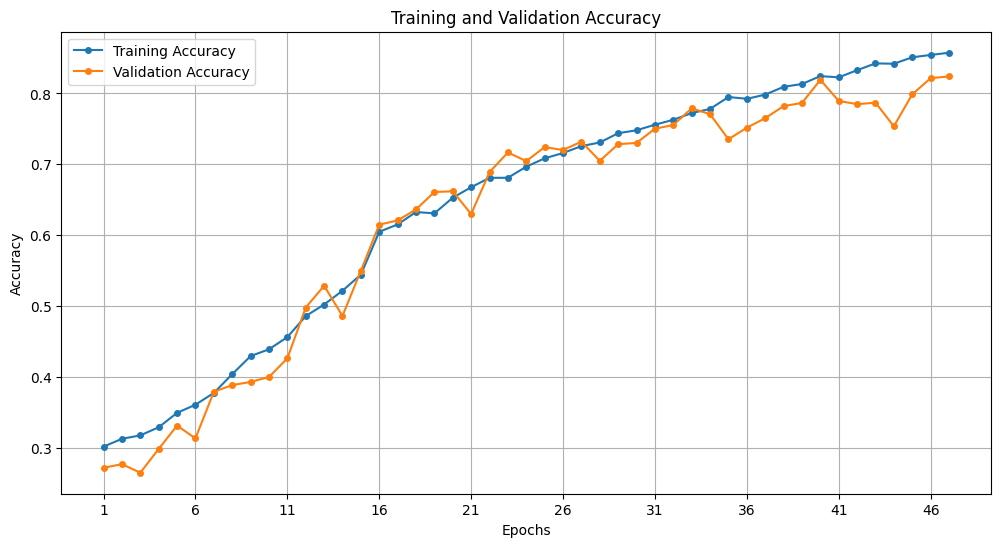

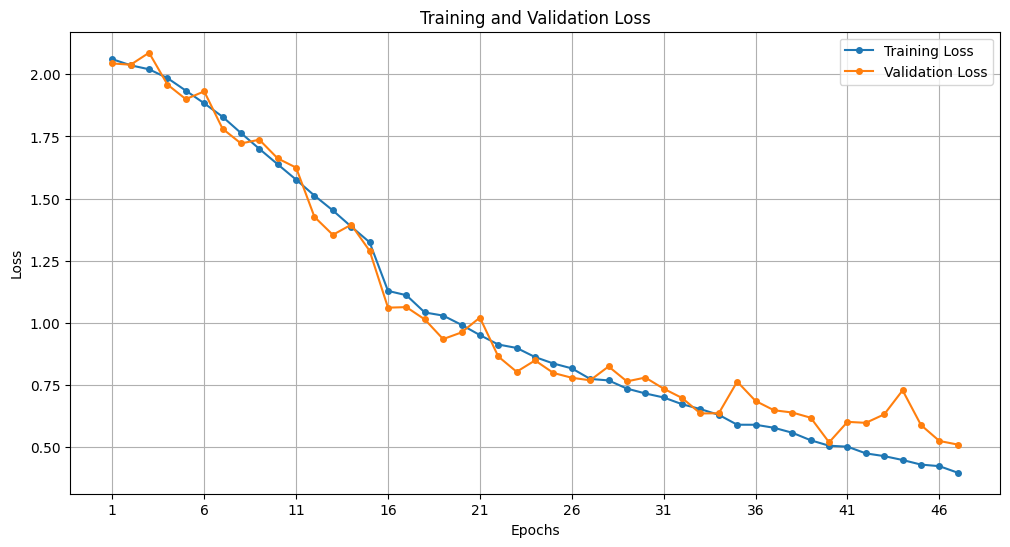

In [ ]:
import json
import matplotlib.pyplot as plt

# Path to the updated training history
history_path = '/content/drive/MyDrive/updated_training_history.json'

# Load the training history
with open(history_path, 'r') as f:
    history = json.load(f)

# Extract accuracy and loss
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']

# Create x-axis values for all epochs
epochs = range(1, len(train_acc) + 1)

# Determine step size for x-axis ticks (e.g., every 5th epoch)
step_size = 5  # Change this to 10, 15, etc., for larger intervals
epoch_ticks = list(range(1, len(train_acc) + 1, step_size))  # Tick every 'step_size' epochs

# ------------------------------
# Plot Accuracy
# ------------------------------
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o', markersize=4)
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', markersize=4)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epoch_ticks)  # Set ticks at intervals
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# Plot Loss
# ------------------------------
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o', markersize=4)
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', markersize=4)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)  # Set ticks at intervals
plt.legend()
plt.grid(True)
plt.show()

Model loaded successfully.
Found 1453 images belonging to 14 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


182/182 ━━━━━━━━━━━━━━━━━━━━ 64s 338ms/step
Training history not found. Accuracy graph skipped.


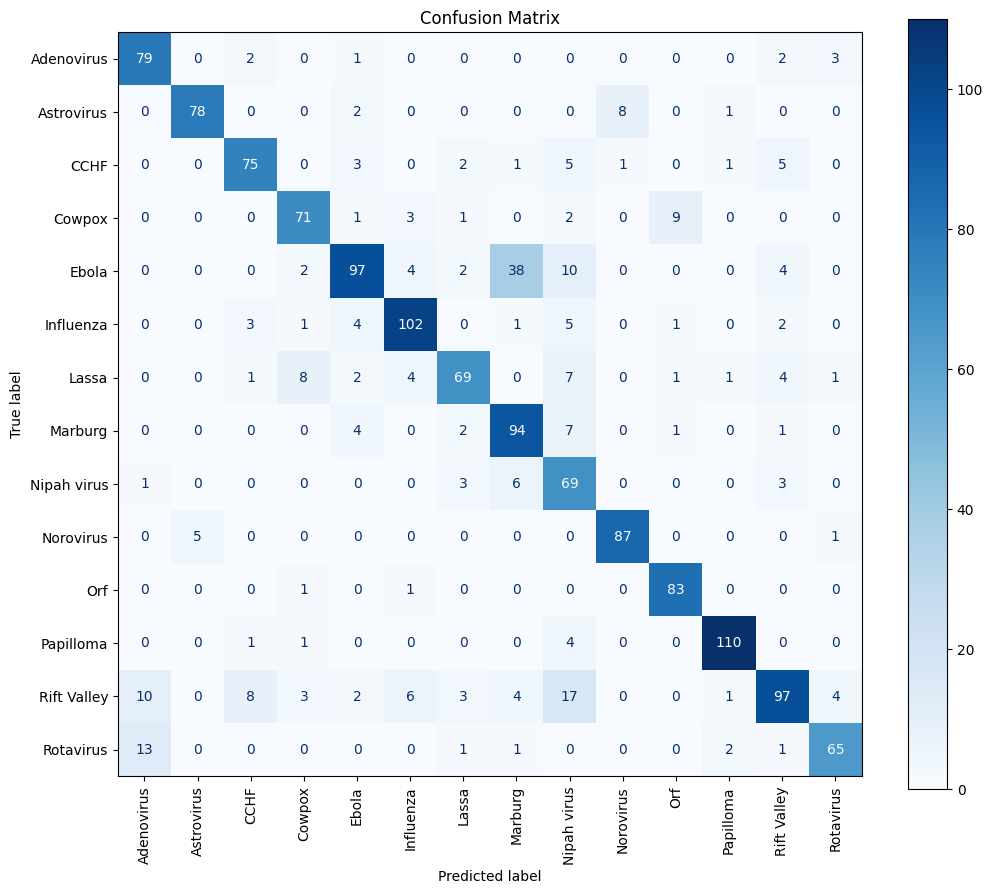

Classification Report:
              precision    recall  f1-score   support

  Adenovirus       0.77      0.91      0.83        87
  Astrovirus       0.94      0.88      0.91        89
        CCHF       0.83      0.81      0.82        93
      Cowpox       0.82      0.82      0.82        87
       Ebola       0.84      0.62      0.71       157
   Influenza       0.85      0.86      0.85       119
       Lassa       0.83      0.70      0.76        98
     Marburg       0.65      0.86      0.74       109
 Nipah virus       0.55      0.84      0.66        82
   Norovirus       0.91      0.94      0.92        93
         Orf       0.87      0.98      0.92        85
   Papilloma       0.95      0.95      0.95       116
 Rift Valley       0.82      0.63      0.71       155
   Rotavirus       0.88      0.78      0.83        83

    accuracy                           0.81      1453
   macro avg       0.82      0.83      0.82      1453
weighted avg       0.82      0.81      0.81      1453



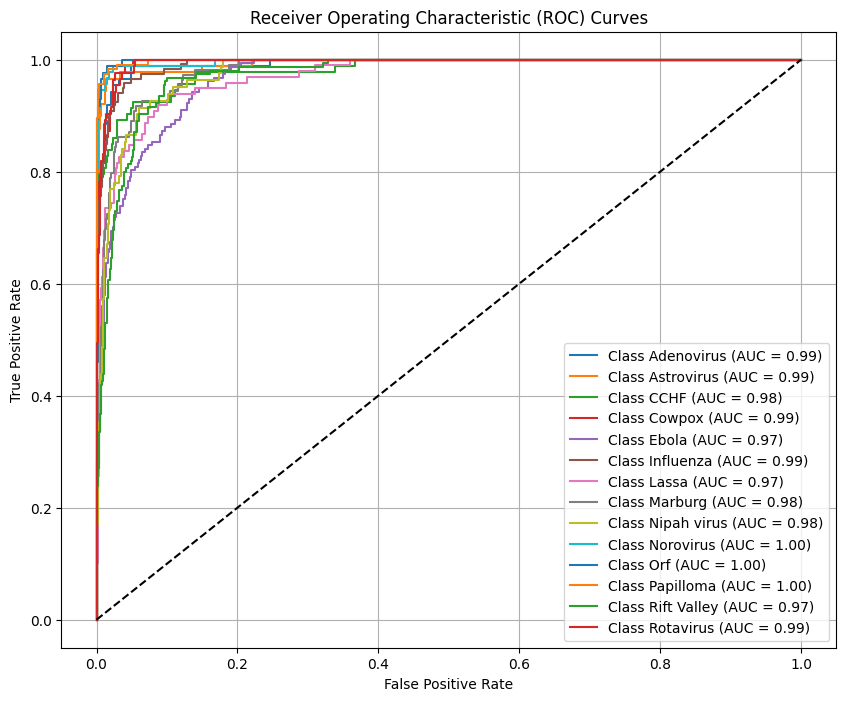

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ------------------------------
# Load the trained model
# ------------------------------
checkpoint_path = '/content/drive/MyDrive/resnet_model_sgd_custom.keras'  # Adjust path if needed
model = load_model(checkpoint_path)
print("Model loaded successfully.")

# ------------------------------
# Load the test dataset
# ------------------------------
test_dir = '/content/drive/MyDrive/new_dataset/test'
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_tensor_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)

# Predict probabilities on the test set
y_true = test_tensor_ds.classes  # True class labels
y_pred_probs = model.predict(test_tensor_ds)  # Probabilities for each class
y_pred = np.argmax(y_pred_probs, axis=1)     # Predicted class labels
class_names = list(test_tensor_ds.class_indices.keys())  # Get class names

# ------------------------------
# 1. Accuracy Graph
# ------------------------------
try:
    history_data = new_history.history  # Use history if training history is available
except NameError:
    print("Training history not found. Accuracy graph skipped.")
else:
    plt.figure(figsize=(10, 6))
    plt.plot(history_data['accuracy'], label='Training Accuracy')
    plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------------------
# 2. Confusion Matrix with Vertical Class Labels
# ------------------------------
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))  # Adjust size if needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())

# Rotate the x-axis class names to vertical
plt.xticks(rotation=90)  # Rotate labels 90 degrees to make them vertical
plt.title('Confusion Matrix')
plt.show()

# ------------------------------
# 3. Precision, Recall, F1-Score
# ------------------------------
print("Classification Report:")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# ------------------------------
# 4. ROC Curve and AUC
# ------------------------------
n_classes = len(class_names)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# One-hot encode y_true for ROC computation
y_true_one_hot = tf.keras.utils.to_categorical(y_true, n_classes)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
